In [1]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
# Data File Import
data = pd.read_csv('747.csv')
time = data['time (min)']
signal_intensity = data['raw light scattering data: detector voltage  (V) detector 11']
absorbance_UV1 = data['UV absorbance data: absorbance  (AU) channel 1']
absorbance_UV2 = data['UV absorbance data: absorbance  (AU) channel 2']

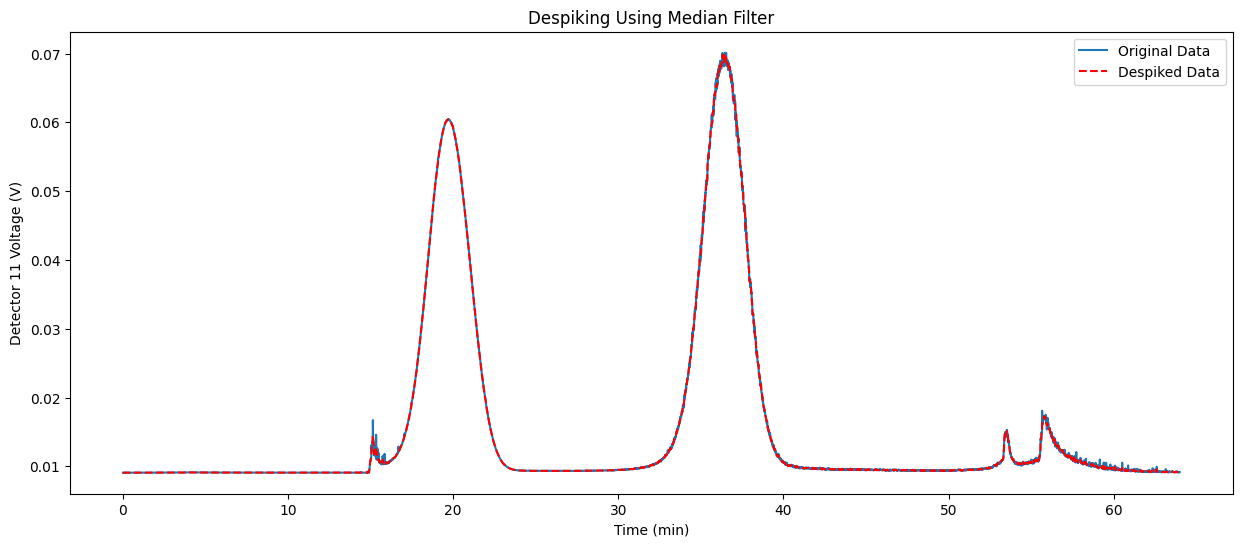

In [43]:
from scipy.signal import medfilt # Libraries used
import matplotlib.pyplot as plt

kernel_size = 5 # Window size
median_signal_intensity = medfilt(signal_intensity,kernel_size) # Median Filter

# Plot the original and despiked data
fig3 = plt.figure(figsize=(15, 6))
plt.plot(time,signal_intensity, label='Original Data')
plt.plot(time,median_signal_intensity,'r--' , label='Despiked Data')
plt.ylabel('Detector 11 Voltage (V)')
plt.xlabel('Time (min)')
plt.title('Despiking Using Median Filter')
plt.legend()
plt.show()

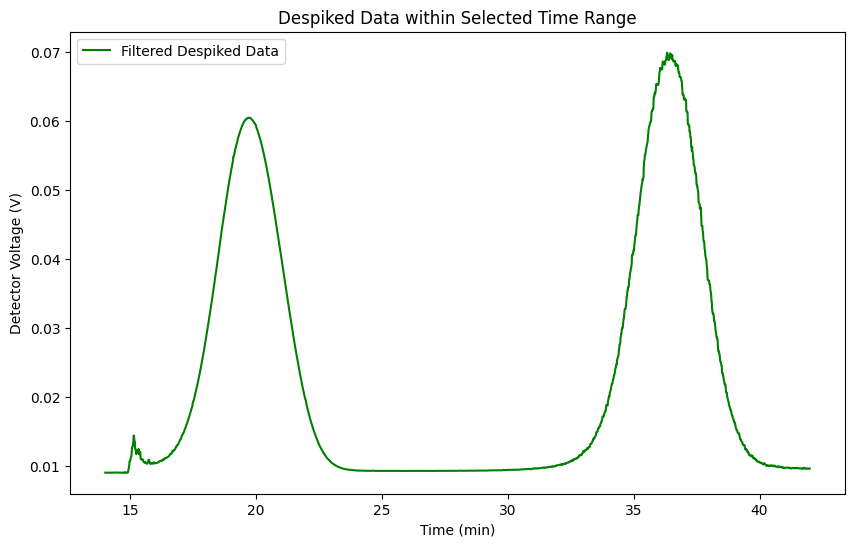

In [47]:
#Definitions
start_time = 14
end_time = 42

# Filter the data to include only defined times
filtered_indices = (time >= start_time) & (time <= end_time)
filtered_time = time[filtered_indices]
filtered_signal = median_signal_intensity[filtered_indices]

# plot
plt.figure(figsize=(10,6))
plt.plot(filtered_time,filtered_signal, label='Filtered Despiked Data',color='green')
plt.xlabel('Time (min)')
plt.ylabel('Detector Voltage (V)')
plt.title('Despiked Data within Selected Time Range')
plt.legend()
plt.show()

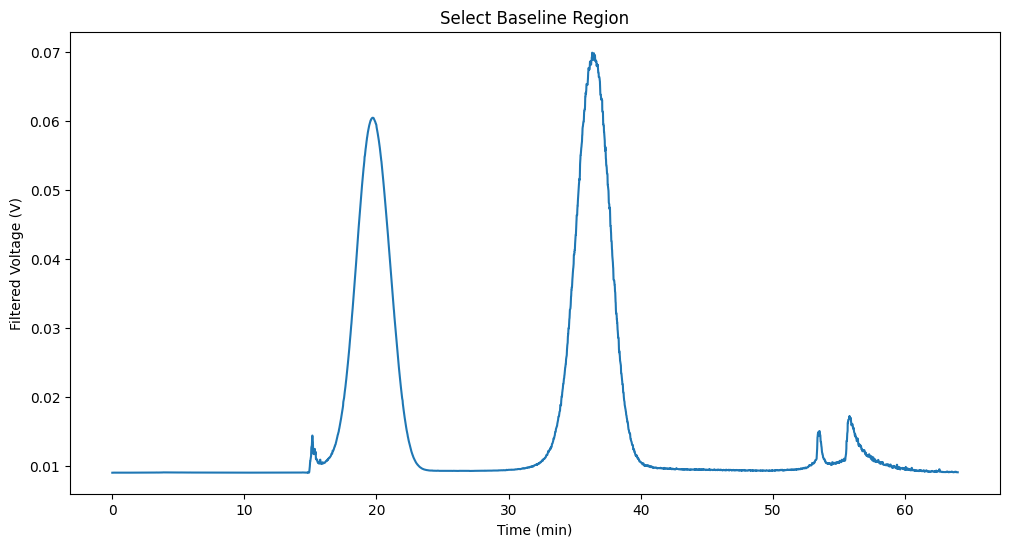

Baseline Value: 0.0151 V


In [54]:
# Plot the filtered voltage to select baseline region
plt.figure(figsize=(12, 6))
plt.plot(time, median_signal_intensity)
plt.xlabel('Time (min)')
plt.ylabel('Filtered Voltage (V)')
plt.title('Select Baseline Region')
plt.show()

# Define baseline region (manual selection)
baseline_start = float(input('Enter baseline start time (min): '))
baseline_end = float(input('Enter baseline end time (min): '))

# Get indices corresponding to baseline region
baseline_indices = np.where((time >= baseline_start) & (time <= baseline_end))[0]

# Calculate baseline value (average)
baseline_value = np.mean(median_signal_intensity[baseline_indices])

print(f'Baseline Value: {baseline_value:.4f} V')

# Subtract baseline from filtered voltage
voltage_corrected = median_signal_intensity - baseline_value

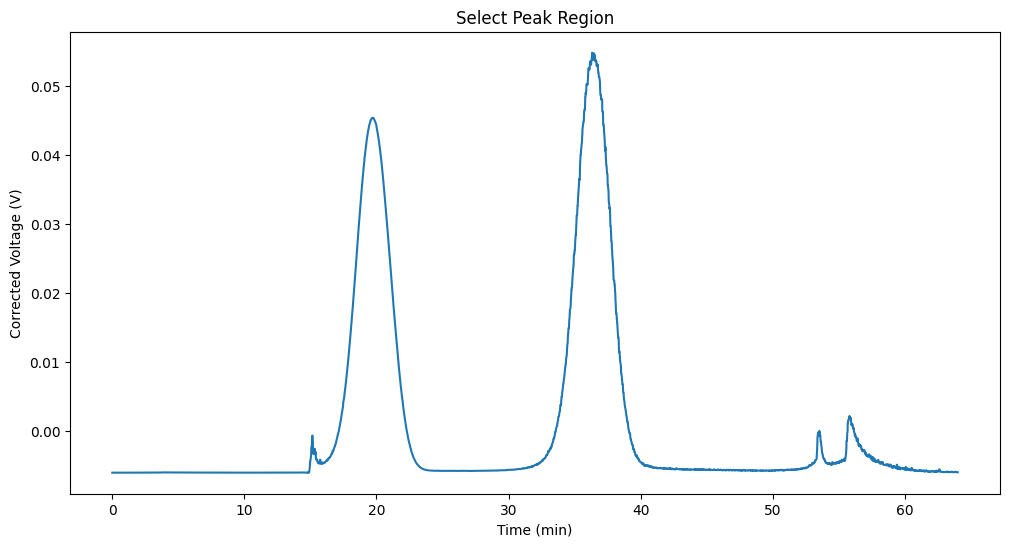

In [55]:
# Plot corrected voltage to select peak region
plt.figure(figsize=(12, 6))
plt.plot(time, voltage_corrected)
plt.xlabel('Time (min)')
plt.ylabel('Corrected Voltage (V)')
plt.title('Select Peak Region')
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_29272\339680447.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(peak_groups))


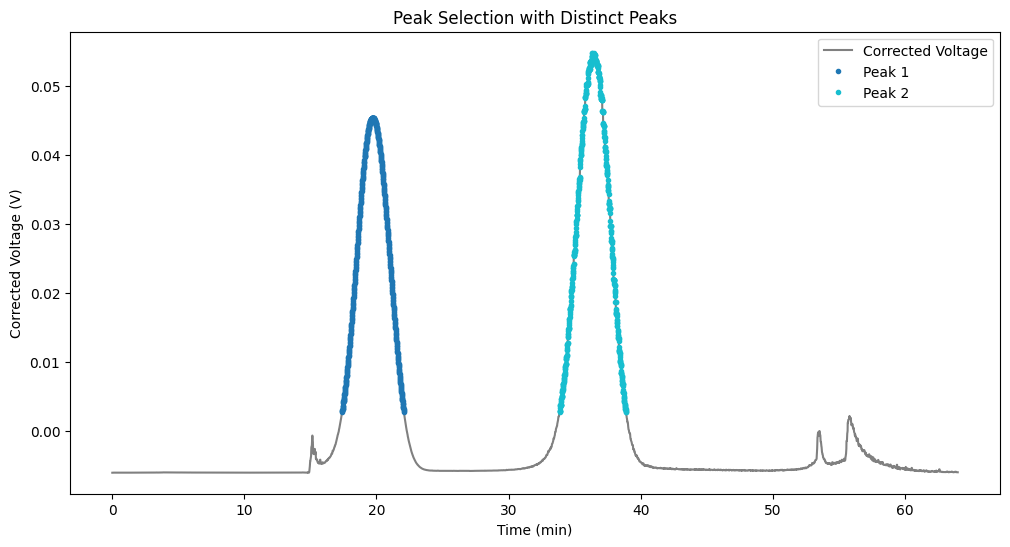

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Automatic peak detection using thresholds
threshold = np.max(voltage_corrected) * 0.05  # Adjust threshold as needed, currently at 5%
peak_indices = np.where(voltage_corrected > threshold)[0]

# Separate peaks based on gaps
gap_threshold = 10  # Set a threshold for the gap
peak_groups = []
current_group = [peak_indices[0]]

for i in range(1, len(peak_indices)):
    if peak_indices[i] - peak_indices[i - 1] > gap_threshold:
        peak_groups.append(current_group)
        current_group = [peak_indices[i]]
    else:
        current_group.append(peak_indices[i])
peak_groups.append(current_group) # Append the last group

# Plot the voltage signal with each peak in a different color
plt.figure(figsize=(12, 6))
plt.plot(time, voltage_corrected, label='Corrected Voltage', color='gray')

# Plot each peak group with a different color
colors = plt.cm.get_cmap('tab10', len(peak_groups))

for i, group in enumerate(peak_groups):
    time_peak = time[group]
    voltage_peak = voltage_corrected[group]
    plt.plot(time_peak, voltage_peak, '.', color=colors(i), label=f'Peak {i+1}')

plt.xlabel('Time (min)')
plt.ylabel('Corrected Voltage (V)')
plt.title('Peak Selection with Distinct Peaks')
plt.legend()
plt.show()

# Store peaks in a dictionary for further use
peak_data = {f'Peak {i+1}': {'time': time[groups], 'voltage': voltage_corrected[groups]} 
             for i, groups in enumerate(peak_groups)}

# Peak data points can be accessed using the peak_data directory

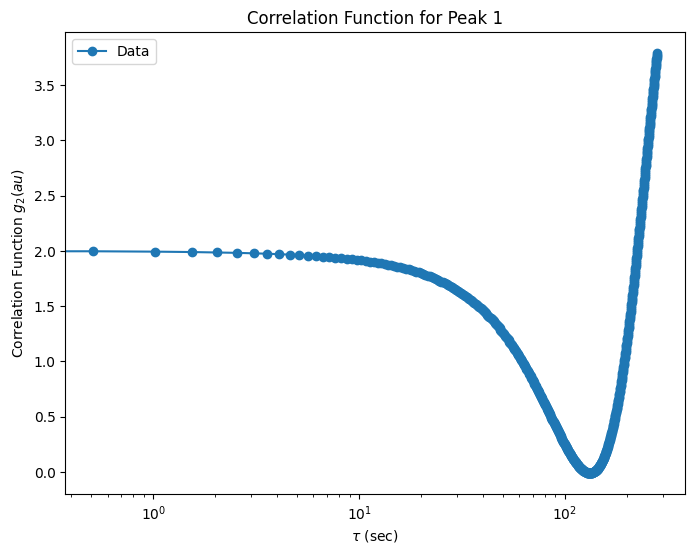

Peak 1:
Fitted A = 0.0123
Fitted Gamma = -9.8402e-03 s^-1
Diffusion Coefficient D = -1.7910e-17 m^2/s
Hydrodynamic radius rh = -12994901.51 nm


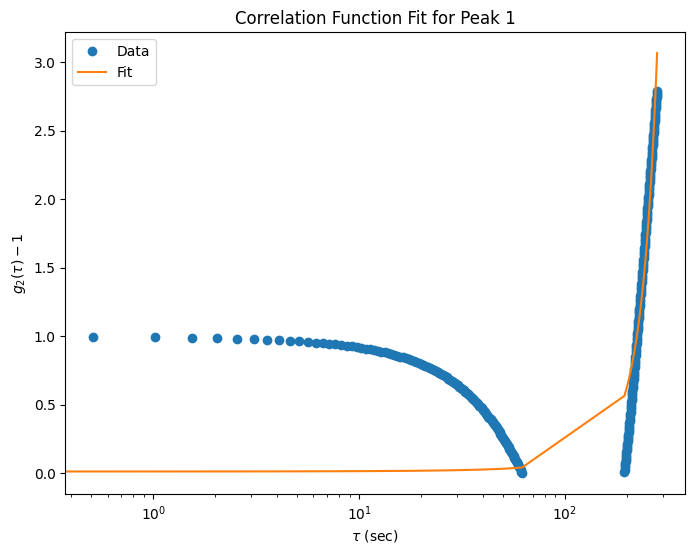

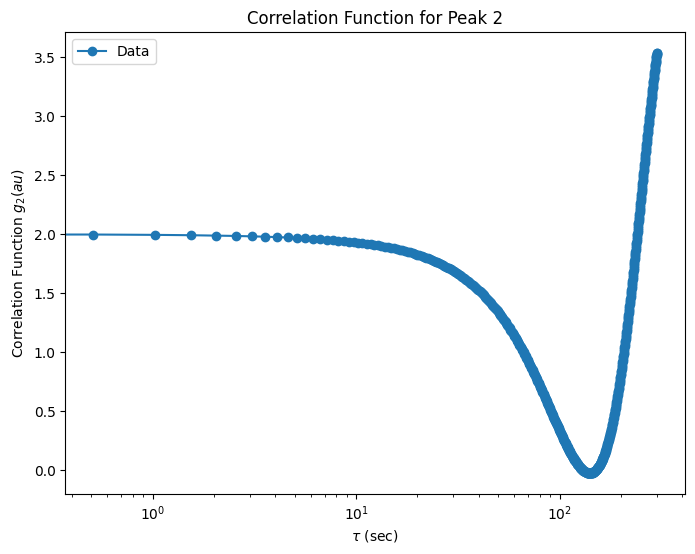

Peak 2:
Fitted A = 0.0197
Fitted Gamma = -8.1995e-03 s^-1
Diffusion Coefficient D = -1.4924e-17 m^2/s
Hydrodynamic radius rh = -15595098.83 nm


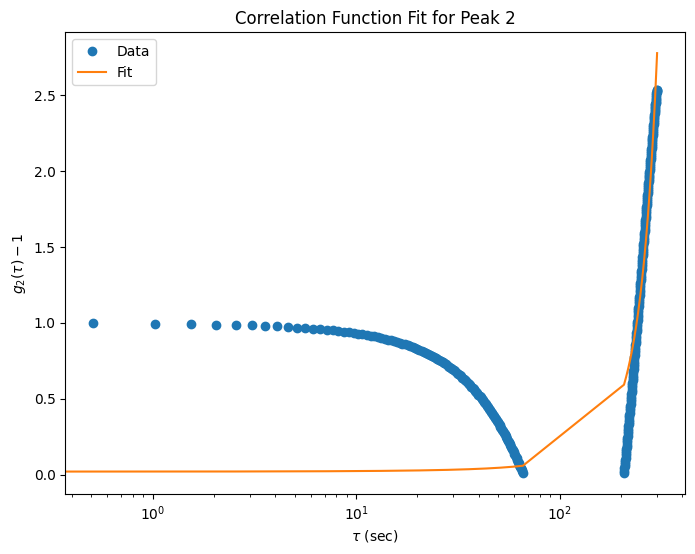

In [63]:
# Constants for water at 23°C
k_B = 1.380649e-23  # Boltzmann constant, J/K
T = 296.15  # Temperature in Kelvin (23 °C)
eta = 0.932e-3  # Viscosity of water at 23°C in Pa·s
lambda_laser = 660e-9  # Wavelength of the laser in meters (660 nm)
n = 1.3325  # Refractive index of water at 23°C
theta = 135 * np.pi / 180  # Scattering angle in radians (135 degrees)

# Function to calculate the correlation function
def calculate_correlation_function(signal):
    N = len(signal)
    mean_intensity = np.mean(signal)
    signal = signal - mean_intensity  # Subtract mean to center the signal
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[N-1:] / ((N - np.arange(N)) * mean_intensity**2)
    g2 = autocorr / autocorr[0] + 1  # Normalize and shift
    return g2

# Function for exponential decay fitting
def exponential_decay(tau, A, Gamma):
    return A * np.exp(-2 * Gamma * tau)

# For each peak in peak_data, perform calculations
for peak_name, peak_info in peak_data.items():
    peak_time = peak_info['time']
    peak_voltage = peak_info['voltage']
    
    # Start and end times are the first and last points in the peak
    start_time = peak_time.iloc[0]
    end_time = peak_time.iloc[-1]
    
    # Calculate the mean intensity
    mean_intensity = np.mean(peak_voltage)
    
    # Calculate g2(tau)
    g2_tau = calculate_correlation_function(peak_voltage)
    
    # Calculate tau values in seconds
    time_interval = (peak_time.iloc[1] - peak_time.iloc[0]) * 60  # Convert from minutes to seconds
    tau_values = np.arange(len(g2_tau)) * time_interval
    
    # Plot the correlation function
    plt.figure(figsize=(8, 6))
    plt.plot(tau_values, g2_tau, 'o-', label='Data')
    plt.xscale('log')
    plt.xlabel(r'$\tau$ (sec)')
    plt.ylabel('Correlation Function $g_2(\tau)$')
    plt.title(f'Correlation Function for {peak_name}')
    plt.legend()
    plt.show()
    
    # Prepare data for fitting
    g2_tau_minus1 = g2_tau - 1
    positive_indices = g2_tau_minus1 > 0
    tau_fit = tau_values[positive_indices]
    g2_fit = g2_tau_minus1[positive_indices]
    
    if len(g2_fit) > 5:
        # Perform the curve fitting
        initial_guess = [np.max(g2_fit), 1.0]
        try:
            popt, pcov = curve_fit(exponential_decay, tau_fit, g2_fit, p0=initial_guess)
            A_fit, Gamma_fit = popt
            
            # Calculate the scattering vector q
            q = (4 * np.pi * n / lambda_laser) * np.sin(theta / 2)
            
            # Calculate the diffusion coefficient D
            D = Gamma_fit / q**2
            
            # Calculate the hydrodynamic radius rh
            rh = k_B * T / (6 * np.pi * eta * D)
            
            print(f"{peak_name}:")
            print(f"Fitted A = {A_fit:.4f}")
            print(f"Fitted Gamma = {Gamma_fit:.4e} s^-1")
            print(f"Diffusion Coefficient D = {D:.4e} m^2/s")
            print(f"Hydrodynamic radius rh = {rh*1e9:.2f} nm")
            
            # Plot the fit
            plt.figure(figsize=(8, 6))
            plt.plot(tau_fit, g2_fit, 'o', label='Data')
            plt.plot(tau_fit, exponential_decay(tau_fit, *popt), '-', label='Fit')
            plt.xscale('log')
            plt.xlabel(r'$\tau$ (sec)')
            plt.ylabel('$g_2(\\tau) - 1$')
            plt.title(f'Correlation Function Fit for {peak_name}')
            plt.legend()
            plt.show()
            
        except RuntimeError:
            print(f"{peak_name}: Curve fitting failed.")
    else:
        print(f"{peak_name}: Not enough data points for fitting.")

In [ ]:
# Define the start and end times for peak 1 (replace with actual values)
start_time = 12.8866
end_time = 14.1943

# Filter the data for peak 1
filtered_indices = (time >= start_time) & (time <= end_time)
filtered_time = time[filtered_indices]
filtered_signal = voltage_corrected[filtered_indices]

# Calculate the mean intensity
mean_intensity = np.mean(filtered_signal)

# Calculate the correlation function
def calculate_correlation_function(signal):
    N = len(signal)
    g2 = np.zeros(N)
    for tau in range(N):
        if tau == 0:
            g2[tau] = 1
        else:
            sum_products = 0
            for t in range(N - tau):
                sum_products += signal[t] * signal[t + tau]
            g2[tau] = sum_products / (N - tau) / (mean_intensity**2)
    return g2

# Calculate g2(tau)
g2_tau = calculate_correlation_function(filtered_signal)

# Plot the correlation function
tau_values = np.arange(len(g2_tau)) * (filtered_time.iloc[1] - filtered_time.iloc[0]) * 60  # Convert to seconds
plt.figure(figsize=(8, 6))
plt.plot(tau_values, g2_tau, 'o-')
plt.xscale('log')
plt.xlabel(r'$\tau$ (sec)')
plt.ylabel('Correlation Function $g_2(\tau)$')
plt.title('Correlation Function for Peak 1')
plt.show()